# To Dos

[x] Add export nodes
[] Add 2050 loads and generation
[] Test storage
[] Test new lines 


We applied the pandapower module to compare Thailand's current 2024 electricity grid and projected 2050 constraints.

Analysis is at a high level- we relied on the division of Thailand into four regions based on the four subdivisions that the Thai EGAT authority uses:
- North
- Northeast
- Central/Bangkok
- South

On top on these four nodes, we added the import and export nodes Thailand is connected to. Namely,
- Imports:
  - Hong Sa coal plant in Laos
  - Nam Ngum dam in Laos
  - Laos-Theun-Hinboun dam in Laos
  - Houay Ho dam in Laos
- Exports:
  - Cambodia
  - Malaysia-Singapore


In [ ]:
#Laos Small Group Project

#This python script models the Laotian power network in 2050 following the Net-Zero Scenario data proposed by the team. The domestic network
#is simplified into 4 regions (North, Central 1, Central 2, South), and generation is distributed along them according to previously identified
#renewable energy potential and land constraints.

#Domestic demand in 2050 is distributed across the 4 regions proportionally to population
#Export demand is based on export commitments to Thailand, Vietnam, China, Myanmar, and Cambodia and following existing infrastructures

#Local voltage levels are at 115kV, while exports to Vietnam and Thailand are at 230kV, with 3 transformers used to upgrade voltage levels

#All input parameters are available in the excel sheet "laos Python Model Inputs" also available in the same GitHub folder

In [ ]:
# Import libraries
import geopandas as gpd
import matplotlib.pyplot as plt

import pandas as pd
import pandapower as pp
import pandapower.plotting as plot

In [ ]:
MODEL_2050 = True

In [ ]:
# Create network
net = pp.create_empty_network() 

In [ ]:
#Read bus data from excel
bus_df= pd.read_excel('ThaiModelInput.xlsx', sheet_name='buses',nrows=10)
#bus_df

In [ ]:
# Create buses
b = {}

for i in bus_df['bus_id']:
  b[i] = pp.create_bus(net, vn_kv = bus_df.loc[bus_df['bus_id']==i, 'vn_kv'].values[0], name = bus_df.loc[bus_df['bus_id']==i, 'name'].values[0], geodata = eval(bus_df.loc[bus_df['bus_id']==i, 'geodata'].values[0]),min_vm_pu=0.85)
net.bus

In [ ]:
# Create one grid connection point
connect_bus = b[0] 
vm_pu = 1.1

# Create the external grid connection
pp.create_ext_grid(net, bus=connect_bus, vm_pu=vm_pu, name = "Slack bus")

In [ ]:
# Import line data from excel file-- from_bus, to_bus, length_km, r_ohm_per_km, x_ohm_per_km, c_nf_per_km, max_i_ka
line_df = pd.read_excel('ThaiModelInput.xlsx', sheet_name='lines',nrows=9)
#line_df

In [ ]:
# Create lines
for i in line_df.index:
  print(i)
  pp.create_line_from_parameters(net, from_bus=b[line_df.loc[i, 'from_bus']],
                                 to_bus=b[line_df.loc[i, 'to_bus']],
                                 length_km=line_df.loc[i, 'length_km'],
                                 r_ohm_per_km=line_df.loc[i, 'r_ohm_per_km'],
                                 x_ohm_per_km=line_df.loc[i, 'x_ohm_per_km'],
                                 c_nf_per_km=line_df.loc[i, 'c_nf_per_km'],
                                 max_i_ka=line_df.loc[i, 'max_i_ka']
                                 ) 
net.line

In [ ]:
# Import Load data from excel-- geolocation, bus (nearest from geolocation), p_mw

load_df = pd.read_excel('ThaiModelInput.xlsx', sheet_name='loads',nrows=10)
#load_df

In [ ]:
# Create loads

for i in load_df['bus_id']:
  pp.create_load(net, 
                 b[i], 
                 p_mw=load_df.loc[load_df['bus_id']==i, 'power_p_mw_2050'  if MODEL_2050 else 'power_p_mw'].values[0], 
                 q_mvar=load_df.loc[load_df['bus_id']==i, 'power_q_mvar_2050'  if MODEL_2050 else 'power_q_mvar'].values[0],
                 name=load_df.loc[load_df['bus_id']==i, 'name'].values[0]
                 )

In [ ]:
net.load

In [ ]:
# Generators imported from excel
vm_pu=1.1

gen_df = pd.read_excel('ThaiModelInput.xlsx', sheet_name='gen',nrows=4)
#gen_df    

In [ ]:
#Generators
for i in gen_df['gen_id']:
  pp.create_sgen(net,
                 bus = gen_df.loc[gen_df['gen_id']==i, 'bus_id'].values[0],
                 p_mw = gen_df.loc[gen_df['gen_id']==i, 'p_mw_2050' if MODEL_2050 else 'p_mw'].values[0],
                 vm_pu = 1, 
                 name = gen_df.loc[gen_df['gen_id']==i, 'name'].values[0]
                 )
net.gen


In [ ]:
#Storage entries are added manually

# pp.create_storage(net,0, p_mw=1348.76, max_e_mwh=25000) #North
# pp.create_storage(net,1, p_mw=4609.91, max_e_mwh=25000) #Central 1
# pp.create_storage(net,2, p_mw=3158.12, max_e_mwh=25000) #Central 2
#pp.create_storage(net,3, p_mw=600, max_e_mwh=25000) #South

In [ ]:
# # Create the transformers

# # First Transformer
# #North (115) to Thailand_north (230)
# lv_bus = net.bus[net.bus.name == 'North'].index.values[0]
# hv_bus = net.bus[net.bus.name == 'trafo_b0'].index.values[0]

# # Parameters assumed equal to those of the 100 MVA 220/110 kV standard type
# sn_mva = 400
# vn_hv_kv = 230
# vn_lv_kv = 115
# vk_percent = 12
# vkr_percent = 0.26
# pfe_kw = 3.2
# i0_percent = 0.06
# pp.create_transformer_from_parameters(net, hv_bus=hv_bus, lv_bus=lv_bus, sn_mva=sn_mva, vn_hv_kv=vn_hv_kv, vn_lv_kv=vn_lv_kv, vkr_percent=vkr_percent, vk_percent=vk_percent, pfe_kw=pfe_kw, i0_percent=i0_percent)

# # Second Transformer
# #Central 1 (115) to Thailand_c1 (230)
# lv_bus = net.bus[net.bus.name == 'Central 1'].index.values[0]
# hv_bus = net.bus[net.bus.name == 'trafo_b1'].index.values[0]


# sn_mva = 4000
# vn_hv_kv = 230
# vn_lv_kv = 115
# vk_percent = 12
# vkr_percent = 0.26
# pfe_kw = 3.2
# i0_percent = 0.06
# pp.create_transformer_from_parameters(net, hv_bus=hv_bus, lv_bus=lv_bus, sn_mva=sn_mva, vn_hv_kv=vn_hv_kv, vn_lv_kv=vn_lv_kv, vkr_percent=vkr_percent, vk_percent=vk_percent, pfe_kw=pfe_kw, i0_percent=i0_percent)

# # Third Transformer
# #South (115) to Vietnam (230)
# lv_bus = net.bus[net.bus.name == 'South'].index.values[0]
# hv_bus = net.bus[net.bus.name == 'trafo_b3'].index.values[0]

# sn_mva = 40000
# vn_hv_kv = 230
# vn_lv_kv = 115
# vk_percent = 12
# vkr_percent = 0.26
# pfe_kw = 3.2
# i0_percent = 0.06
# pp.create_transformer_from_parameters(net, hv_bus=hv_bus, lv_bus=lv_bus, sn_mva=sn_mva, vn_hv_kv=vn_hv_kv, vn_lv_kv=vn_lv_kv, vkr_percent=vkr_percent, vk_percent=vk_percent, pfe_kw=pfe_kw, i0_percent=i0_percent)

<Axes: >

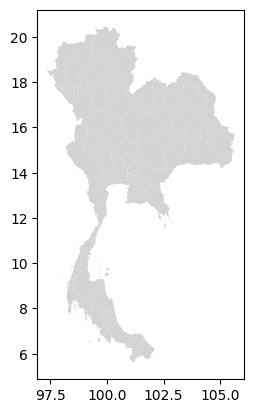

In [17]:
thailand = gpd.read_file('thai.shp')
thailand.plot(ax=plt.gca(), color='lightgrey')


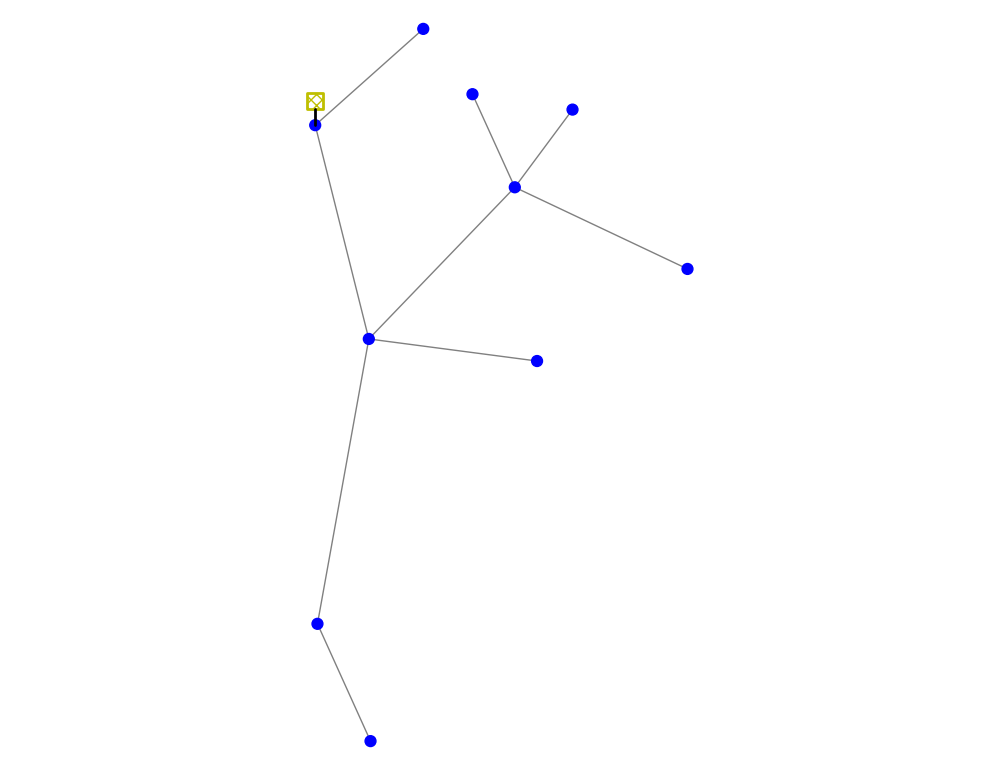

<Axes: >

In [18]:
pp.plotting.simple_plot(net)

In [19]:
# Run the network using the NR algorithm
pp.runpp(net,algorithm='nr', max_iteration=10000);


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)



LoadflowNotConverged: Power Flow nr did not converge after 100000 iterations!

In [ ]:
net.line

In [ ]:
cmap_list=[(0, "green"), (50, "yellow"), (100, "red")]
cmap, norm = plot.cmap_continuous(cmap_list)

lc = plot.create_line_collection(net, net.line.index, zorder=1, cmap=cmap, norm=norm, linewidths=2)
#plot.draw_collections([lc], figsize=(8,6))


ideal_color = "#4cd137"
too_high_color = "blue"
too_low_color = "yellow"
very_low_color = "red"
cmap_list=[(0.8, very_low_color), (0.9, too_low_color), (1.0, ideal_color), (1.06, too_high_color)] #+6 and -10 percent for voltage regulations
cmap, norm = plot.cmap_continuous(cmap_list)
bc = plot.create_bus_collection(net, net.bus.index, size=0.2, zorder=2, cmap=cmap, norm=norm)

# Plot the map of Thailand as the background
fig, ax = plt.subplots(figsize=(8, 6))
thailand.plot(ax=ax, color='lightgrey')


plot.draw_collections([lc,bc], figsize=(8,6),ax=ax)

In [ ]:
# Define the color map for voltage regulation
ideal_color = "#4cd137"
too_high_color = "blue"
too_low_color = "red"
cmap_list = [(0.8, "red"), (0.9, "yellow"), (1.0, ideal_color), (1.06, too_high_color)]  # +6 and -10 percent for voltage regulations
cmap, norm = plot.cmap_continuous(cmap_list)

# Plot the map of Thailand as the background
fig, ax = plt.subplots(figsize=(8, 6))
thailand.plot(ax=ax, color='lightgrey')

# Create bus and line collections
lc = plot.create_line_collection(net, net.line.index, color="grey", linewidths=2, use_bus_geodata=True, zorder=1)
bc = plot.create_bus_collection(net, net.bus.index, size=0.1, zorder=2, cmap=cmap, norm=norm)

# Draw the collections
plot.draw_collections([lc, bc], ax=ax)

plt.show()


In [ ]:
# Print the elements of the network
net

In [ ]:
# Display line results
net.res_line

In [ ]:
# Display bus results
net.res_bus

In [ ]:
# Display generator results
net.res_gen

In [ ]:
#Display transformer results
net.res_trafo

In [ ]:


# Creating the line color collection
cmap_list=[(40, "yellow"), (70, "orange"), (80, "red")]
cmap, norm = plot.cmap_continuous(cmap_list)
lc = plot.create_line_collection(net, net.line.index, zorder=1, cmap=cmap, norm=norm, linewidths=3)

# Creating the bus color collection
cmap_list=[(0.7, "yellow"), (0.9, "blue"), (1.0, "green")]
cmap, norm = plot.cmap_continuous(cmap_list)
bc = plot.create_bus_collection(net, net.bus.index, size=0.1, zorder=2, cmap=cmap, norm=norm)

plot.draw_collections([lc, bc], figsize=(25,8))

In [ ]:
# Define the line color map
line_cmap_list = [(40, "yellow"), (70, "orange"), (80, "red")]
line_cmap, line_norm = plot.cmap_continuous(line_cmap_list)

# Create the line color collection
lc = plot.create_line_collection(net, net.line.index, zorder=1, cmap=line_cmap, norm=line_norm, linewidths=3)

# Define the bus color map
bus_cmap_list = [(0.7, "yellow"), (0.9, "blue"), (1.0, "green")]
bus_cmap, bus_norm = plot.cmap_continuous(bus_cmap_list)

# Create the bus color collection
bc = plot.create_bus_collection(net, net.bus.index, size=0.1, zorder=2, cmap=bus_cmap, norm=bus_norm)

# Plot the map of Thailand as the background
fig, ax = plt.subplots(figsize=(25, 8))
thailand.plot(ax=ax, color='lightgrey')

# Draw the collections
plot.draw_collections([lc, bc], ax=ax)

plt.show()

In [ ]:
#Print results to an excel file
#pp.to_excel(net, "results.xlsx") 